# 1. 导入模块和库

In [15]:
import time
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, classification_report

# 2. 导入数据

In [16]:
data = pd.read_csv(r"F:\Code_Data\2_Rocks_Spectrum_Reflectance_essay_30_origin_modify_2.csv",encoding='utf-8') #encoding='GBK',防止中文乱码
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

In [17]:
X.shape, y.shape

((11828, 2151), (11828,))

# 3. 数据预处理

In [18]:
# SG（Savitzky-Golay）平滑处理
# 输入信号 y，窗口大小 window_length，多项式阶数 polyorder
X_SG = savgol_filter(X, 5, 2)
X_SG_mms = MinMaxScaler().fit_transform(X_SG)
Label = LabelEncoder().fit_transform(y)

In [19]:
[*zip(np.unique(Label),LabelEncoder().fit(y).classes_)]

[(0, '01_辉绿岩'),
 (1, '02_斜长岩'),
 (2, '03_正长岩'),
 (3, '05_辉石闪长岩'),
 (4, '07_花岗斑岩'),
 (5, '09_橄榄岩'),
 (6, '10_闪长玢岩'),
 (7, '11_粗粒花岗岩'),
 (8, '12_斑状花岗岩'),
 (9, '13_斜长花岗岩'),
 (10, '17_角砾凝灰岩'),
 (11, '26_紫色页岩'),
 (12, '28_炭质页岩'),
 (13, '31_泥质灰岩'),
 (14, '33_泥晶石灰岩'),
 (15, '37_石英砾岩'),
 (16, '38_复成份砾岩'),
 (17, '41_石英砂岩'),
 (18, '42_细砂岩'),
 (19, '43_高岭石粘土岩'),
 (20, '44_蒙脱石粘土岩'),
 (21, '45_伊利石粘土岩'),
 (22, '49_石英岩②'),
 (23, '51_云英岩'),
 (24, '55_粗晶大理岩'),
 (25, '56_雪白大理岩'),
 (26, '58_花岗片麻岩'),
 (27, '59_绿泥石片岩'),
 (28, '60_含榴白云母片岩'),
 (29, '63_云母石英片岩'),
 (30, '64_十字石片岩'),
 (31, '66_蛇纹岩'),
 (32, '67_石榴子石矽卡岩')]

In [20]:
data.iloc[:,1:-1] = X_SG_mms
data.iloc[:, -1] = Label
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

In [21]:
# X_dr = PCA(29).fit_transform(X)
X_dr = X

# 4. PCA 降维

#### （1）画累计方差贡献率曲线，找最佳降维后维度的范围

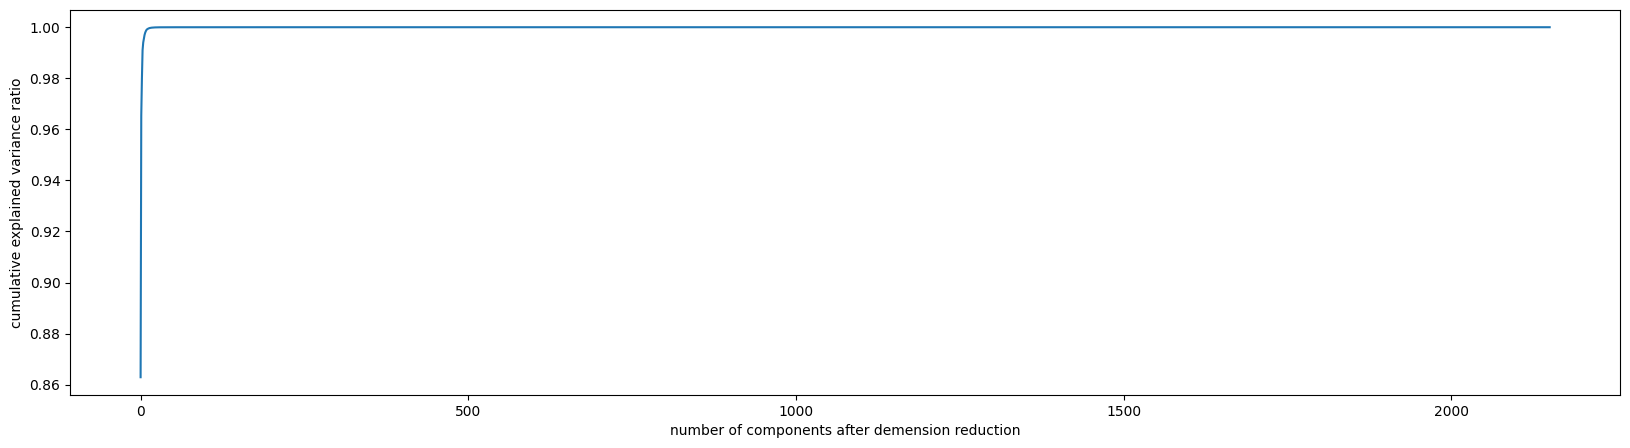

In [10]:
pca_line = PCA().fit(X) #n_components默认取值min(X.shape)=2151
plt.figure(figsize=[20,5])
plt.plot(np.cumsum(pca_line.explained_variance_ratio_))
plt.xlabel("number of components after demension reduction")
plt.ylabel("cumulative explained variance ratio")
plt.show()

#### （2）降维后维度的学习曲线，继续缩小最佳维度的范围

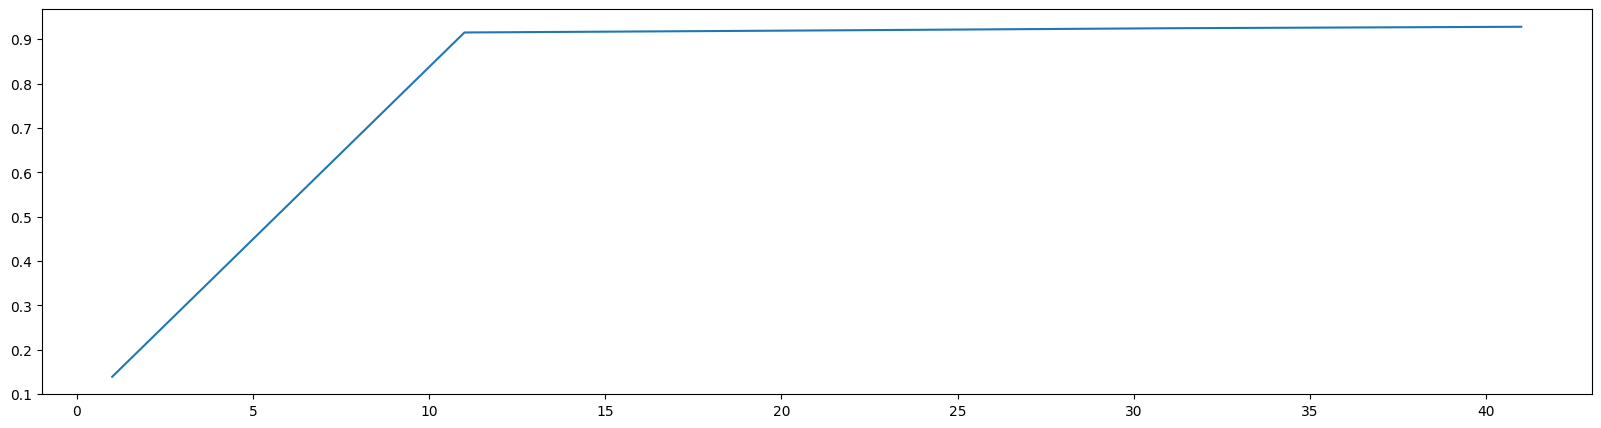

In [11]:
score = []
for i in range(1,51,10):
    X_dr = PCA(i).fit_transform(X)
    once = cross_val_score(RFC(n_estimators=10,random_state=0),X_dr,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(1,51,10),score)
plt.show()

#### （3）细化学习曲线，找出降维后的最佳维度

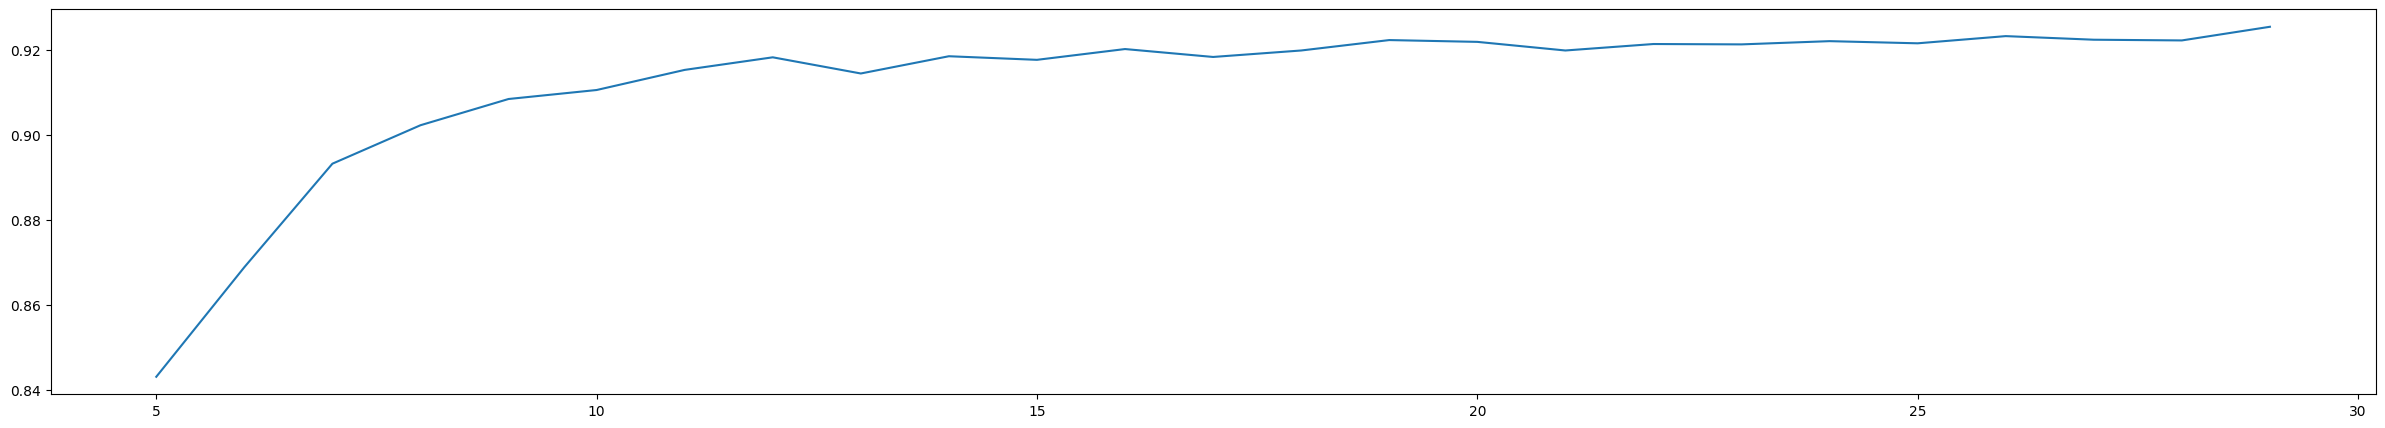

In [12]:
score = []
for i in range(5,30):
    X_dr = PCA(i).fit_transform(X)
    once = cross_val_score(RFC(n_estimators=10,random_state=0),X_dr,y,cv=5).mean()
    score.append(once)
plt.figure(figsize=[30,5])
plt.plot(range(5,30),score)
plt.show()

In [13]:
print(max(score),range(5,30)[score.index(max(score))])

0.9254297044636939 29


#### （4）导入找出的最佳维度进行降维，查看模型效果

In [14]:
X_dr = PCA(29).fit_transform(X)

In [15]:
cv = KFold(n_splits=5,shuffle=True,random_state=0)

rfc = RFC(n_estimators=10,random_state=0)

score_original = cross_val_score(rfc,X_dr,y
                        ,scoring='accuracy'
                        ,cv=cv #交叉验证模式
                        ,verbose=False #是否打印进程
                        ,n_jobs=-1 #线程数
                        ,error_score='raise' #如果在某个折叠中出现错误，会引发一个异常
                       ).mean()
score_original

0.9614475327892145

# 5. 建模，训练，查看结果

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dr, y, test_size=0.3, random_state=0)

In [22]:
rfc = RFC(n_estimators=10,random_state=0)
rfc = rfc.fit(X_train, Y_train)
score_r = rfc.score(X_test, Y_test)
print("Random Forest:{}".format(score_r))

Random Forest:0.9584848484848485


In [23]:
rfc.predict(X_test) #predict返回每个测试样本的分类/回归结果

array([25, 12,  2, ...,  8,  8, 24])

In [24]:
rfc.predict(X_test).shape #4620/11548=0.4，符合测试集划分的比例

(3300,)

In [25]:
rfc.predict_proba(X_test) #这个接口返回每个测试样本对应的被分到每一类标签的概率，标签有几个分类就返回几个概率

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
rfc.score(X_train,Y_train), rfc.score(X_test,Y_test)

(0.9962327877370746, 0.9584848484848485)

# 6. 手动调参（Manual Hyperparameter Tuning）学习曲线+网格搜索

先利用学习曲线找出最佳的n_estimators值，然后基于模型的泛化误差理论，利用网格搜索寻找使得泛化误差最低的参数设置

#### （1）调整 n_estimators 

#### n_estimators的学习曲线

0.9878766505617957 191


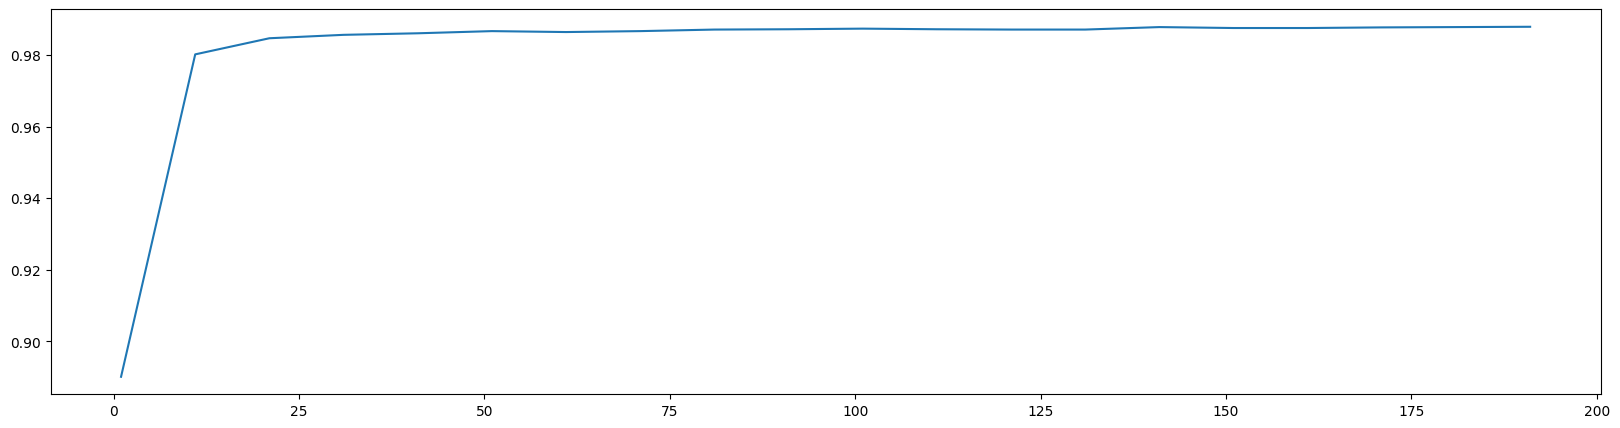

In [31]:
scorel = []
for i in range(0,200,10):
    rfc = RFC(n_estimators=i+1
              ,n_jobs=-1
              ,random_state=0)
    score = cross_val_score(rfc, X_dr, y, cv=5).mean()
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

在确定好的范围内，进一步细化学习曲线

In [ ]:
scorel = []
for i in range(185,195):
    rfc = RFC(n_estimators=i
              ,n_jobs=-1
              ,random_state=0)
    score = cross_val_score(rfc, X_dr, y, cv=5).mean()
    scorel.append(score)
print(max(scorel),([*range(185,195)][scorel.index(max(scorel))]))
plt.figure(figsize=[10,5])
plt.plot(range(185,195),scorel)
plt.show()

#### （2）调整max_depth

In [54]:
param_grid = {'max_depth':np.arange(30,50,1)}
rfc = RFC(n_estimators=194
          ,random_state=0
         )
GS = GridSearchCV(rfc,param_grid,cv=5)
GS.fit(X_dr,y)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=194, random_state=0),
             param_grid={'max_depth': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49])})

In [55]:
GS.best_params_

{'max_depth': 30}

In [57]:
GS.best_score_

0.9880498107349558

In [61]:
#max_depth返回最小值，准确率无变化，不需要调整
#因为max_depth，min_samples_leaf和min_samples_split是剪枝参数，是减小复杂度的参数，进一步调整可能会导致模型泛化误差增大
#我们已经非常接近模型的上限，模型很可能没有办法再进步了
#此时我们的模型泛化误差处于最低点的左侧
#那我们这就来调整一下max_features，看看模型如何变化

#### （3）调整min_samples_leaf

In [ ]:
param_grid={'min_samples_leaf':np.arange(1, 1+50, 1)}
rfc = RFC(n_estimators=194
          ,random_state=0
         )
GS = GridSearchCV(rfc,param_grid,cv=5)
GS.fit(X_dr,y)

In [ ]:
GS.best_params_

In [ ]:
GS.best_score_

#### （4）调整min_samples_split

In [ ]:
param_grid={'min_samples_split':np.arange(2, 2+20, 1)}
rfc = RFC(n_estimators=194
                            ,random_state=0
                            )
GS = GridSearchCV(rfc,param_grid,cv=5)
GS.fit(X_dr,y)

In [ ]:
GS.best_params_

In [ ]:
GS.best_score_

#### （5）调整max_features

In [63]:
param_grid = {'max_features':np.arange(5,30,1)} #取最小（sqrt(n_features)）到最大特征数
rfc = RFC(n_estimators=194
          ,random_state=0
         )
GS = GridSearchCV(rfc,param_grid,cv=5)
GS.fit(X_dr,y)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=194, random_state=0),
             param_grid={'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29])})

In [64]:
GS.best_params_

{'max_features': 5}

In [65]:
GS.best_score_

0.9880498107349558

#### （6）调整criterion

In [66]:
param_grid = {'criterion':['gini', 'entropy']}
rfc = RFC(n_estimators=194
          ,random_state=0
         )
GS = GridSearchCV(rfc,param_grid,cv=5)
GS.fit(X_dr,y)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=194, random_state=0),
             param_grid={'criterion': ['gini', 'entropy']})

In [67]:
GS.best_params_

{'criterion': 'entropy'}

In [68]:
GS.best_score_

0.9892623444117596

#### （7）调整完毕，总结出模型的最佳参数

In [32]:
cv = KFold(n_splits=5,shuffle=True,random_state=0)

rfc = RFC(n_estimators=100
          ,criterion='entropy'
          ,random_state=0
         )

score_MHT = cross_val_score(rfc,X_dr,y
                        ,scoring='accuracy'
                        ,cv=cv #交叉验证模式
                        ,verbose=False #是否打印进程
                        ,n_jobs=-1 #线程数
                        ,error_score='raise' #如果在某个折叠中出现错误，会引发一个异常
                       ).mean()
score_MHT

0.9983546408838743

# 7. Optuna——随机网格搜索调参

#### （1）构建目标函数及定义参数空间

In [11]:
def optuna_objective(trial):

    #定义参数空间
    n_estimators = trial.suggest_int("n_estimators",50,150,1) #整数型，(参数名称，下界，上界，步长)
    max_depth = trial.suggest_int("max_depth",30,50,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf",1,51,1)
    min_samples_split = trial.suggest_int("min_samples_split",2,22,1)

    #定义评估器
    #需要优化的参数由上述参数空间决定
    #不需要优化的参数则直接填写具体值
    rfc = RFC(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_samples_leaf = min_samples_leaf
              ,min_samples_split = min_samples_split
              ,random_state=0
              ,verbose=False
              ,n_jobs=-1
             )

    #交叉验证过程，输出准确率(accuracy)
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    score = cross_val_score(rfc,X_dr,y
                            ,scoring='accuracy'
                            ,cv=cv #交叉验证模式
                            ,verbose=False #是否打印进程
                            ,n_jobs=-1 #线程数
                            ,error_score='raise' #如果在某个折叠中出现错误，会引发一个异常
                           )
    #最终输出平均准确率
    return np.mean(score)

#### （2）定义优化目标函数的具体流程

In [12]:
def optimizer_optuna(n_trials, algo):

    #定义使用随机网格搜索
    sampler = optuna.samplers.RandomSampler(seed=0)

    #实际优化过程，首先实例化优化器
    study = optuna.create_study(sampler = sampler #要使用的具体算法
                                ,direction="maximize" #优化的方向，可以填写minimize或maximize
                                #,storage="sqlite:///db.sqlite3" # Specify the storage URL here.
                                #,study_name="quadratic-simple"
                               )
    #开始优化，n_trials为允许的最大迭代次数
    #由于参数空间已经在目标函数中定义好，因此不需要输入参数空间
    study.optimize(optuna_objective #目标函数
                   ,n_trials=n_trials #最大迭代次数（包括最初的观测值的）
                   ,show_progress_bar=True #要不要展示进度条呀？
                  )

    #可直接从优化好的对象study中调用优化的结果
    #打印最佳参数与最佳损失值
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")

    return study.best_trial.params, study.best_trial.values

#### （3）执行优化操作

In [13]:
def optimized_optuna_search_and_report(n_trials, algo):
    start_time = time.time()

    # 进行随机网格搜索优化
    best_params, best_score = optimizer_optuna(n_trials, algo)

    # 打印最佳参数和分数
    print("\n","\n","best params: ", best_params,
          "\n","\n","best score: ", best_score,
          "\n")

    end_time = time.time()
    time_random = (end_time - start_time) / 60  # 转换为分钟
    print(f"Optimization completed in {time_random} minutes.")

    return best_params, best_score, time_random

# 执行优化
best_params, best_score, time_random = optimized_optuna_search_and_report(5, "Random")

[I 2023-09-13 14:27:39,252] A new study created in memory with name: no-name-59fd6b19-bbdc-463d-a7af-3c94c1946a86
Best trial: 0. Best value: 0.943186:  20%|█████████▏                                    | 1/5 [01:47<07:08, 107.21s/it]

[I 2023-09-13 14:29:28,765] Trial 0 finished with value: 0.9431858660123418 and parameters: {'n_estimators': 105, 'max_depth': 45, 'max_features': 20, 'min_samples_leaf': 28, 'min_samples_split': 10}. Best is trial 0 with value: 0.9431858660123418.


Best trial: 0. Best value: 0.943186:  40%|██████████████████▍                           | 2/5 [03:46<05:42, 114.29s/it]

[I 2023-09-13 14:31:28,006] Trial 1 finished with value: 0.9143563770755183 and parameters: {'n_estimators': 115, 'max_depth': 39, 'max_features': 28, 'min_samples_leaf': 50, 'min_samples_split': 10}. Best is trial 0 with value: 0.9431858660123418.


Best trial: 0. Best value: 0.943186:  60%|███████████████████████████▌                  | 3/5 [05:14<03:24, 102.19s/it]

[I 2023-09-13 14:32:55,792] Trial 2 finished with value: 0.93287156492881 and parameters: {'n_estimators': 129, 'max_depth': 41, 'max_features': 19, 'min_samples_leaf': 48, 'min_samples_split': 3}. Best is trial 0 with value: 0.9431858660123418.


Best trial: 0. Best value: 0.943186:  80%|█████████████████████████████████████▌         | 4/5 [06:11<01:24, 84.62s/it]

[I 2023-09-13 14:33:53,489] Trial 3 finished with value: 0.9249247711143955 and parameters: {'n_estimators': 58, 'max_depth': 30, 'max_features': 26, 'min_samples_leaf': 40, 'min_samples_split': 20}. Best is trial 0 with value: 0.9431858660123418.


Best trial: 4. Best value: 0.944623: 100%|███████████████████████████████████████████████| 5/5 [07:42<00:00, 92.46s/it]

[I 2023-09-13 14:35:23,847] Trial 4 finished with value: 0.9446231049808868 and parameters: {'n_estimators': 148, 'max_depth': 46, 'max_features': 16, 'min_samples_leaf': 40, 'min_samples_split': 4}. Best is trial 4 with value: 0.9446231049808868.

 
 best params:  {'n_estimators': 148, 'max_depth': 46, 'max_features': 16, 'min_samples_leaf': 40, 'min_samples_split': 4} 
 
 best score:  [0.9446231049808868] 


 
 best params:  {'n_estimators': 148, 'max_depth': 46, 'max_features': 16, 'min_samples_leaf': 40, 'min_samples_split': 4} 
 
 best score:  [0.9446231049808868] 

Optimization completed in 7.744440325101217 minutes.



E:\Anaconda\envs\DL\lib\site-packages\joblib\_memmapping_reducer.py:598: UserWarning: Failed to delete temporary folder: C:\Users\Public\Documents\Wondershare\CreatorTemp\joblib_memmapping_folder_5304_c09e3d24bf0143ca8a804e6bb626ead0_4e345ee223874762b7ade77d35cc4ffa
  warnings.warn("Failed to delete temporary folder: {}"
E:\Anaconda\envs\DL\lib\site-packages\joblib\_memmapping_reducer.py:598: UserWarning: Failed to delete temporary folder: C:\Users\Public\Documents\Wondershare\CreatorTemp\joblib_memmapping_folder_5304_9df28917e19e42178d120e48f5fd13cb_209d41a4877147539b5dfa6716bb61ae
  warnings.warn("Failed to delete temporary folder: {}"
E:\Anaconda\envs\DL\lib\site-packages\joblib\_memmapping_reducer.py:598: UserWarning: Failed to delete temporary folder: C:\Users\Public\Documents\Wondershare\CreatorTemp\joblib_memmapping_folder_5304_84146c25c0bc40bfa94854c2acaa5818_de1f7b0198bd46adb85be68ce94217d7
  warnings.warn("Failed to delete temporary folder: {}"
E:\Anaconda\envs\DL\lib\site-p

# 8. Optuna——遗传算法搜索调参

#### （1）构建目标函数及定义参数空间

In [25]:
def optuna_objective(trial):

    #定义参数空间
    n_estimators = trial.suggest_int("n_estimators",50,150,1) #整数型，(参数名称，下界，上界，步长)
    max_depth = trial.suggest_int("max_depth",30,50,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf",1,51,1)
    min_samples_split = trial.suggest_int("min_samples_split",2,22,1)

    #定义评估器
    #需要优化的参数由上述参数空间决定
    #不需要优化的参数则直接填写具体值
    rfc = RFC(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_samples_leaf = min_samples_leaf
              ,min_samples_split = min_samples_split
              ,random_state=0
              ,verbose=False
              ,n_jobs=-1
             )

    #交叉验证过程，输出准确率(accuracy)
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    score = cross_val_score(rfc,X_dr,y
                            ,scoring='accuracy'
                            ,cv=cv #交叉验证模式
                            ,verbose=False #是否打印进程
                            ,n_jobs=-1 #线程数
                            ,error_score='raise' #如果在某个折叠中出现错误，会引发一个异常
                           )
    #最终输出平均准确率
    return np.mean(score)

#### （2）定义优化目标函数的具体流程

In [26]:
def optimizer_optuna(n_trials, algo):

    #定义使用随机网格搜索
    sampler = optuna.samplers.NSGAIISampler(population_size=50  # int，种群大小，即每代中包含的个体数量。默认 50
                                           ,mutation_prob=1.0 # float，变异概率，指定了在交叉之后每个个体发生变异的概率。默认 1.0。
                                           ,crossover_prob=1.0  # float，交叉概率，指定了在每次交叉操作中，一个个体与另一个个体产生子代的概率。默认 1.0
                                           #,crossover_operator  # str，交叉操作符的类型。可选 "sbx"（模拟二进制交叉）和 "ux"（单点均匀交叉）。默认"sbx"
                                           #,mutation_operator  # str，变异操作符的类型。可选 "polynomial"（多项式变异）和 "random"（随机变异）。默认"polynomial"
                                           #,eta= # float，多项式变异操作的参数，用于控制变异的强度。较高的值表示更强的变异。默认20.0。
                                           #,crossover_eta= # float，模拟二进制交叉操作的参数，用于控制交叉的强度。较低的值表示更强的交叉。默认20.0。
                                           #,max_generations=  # int，最大的迭代代数。默认值为 None，表示没有最大代数限制。
                                           )

    #实际优化过程，首先实例化优化器
    study = optuna.create_study(sampler = sampler #要使用的具体算法
                                ,direction="maximize" #优化的方向，可以填写minimize或maximize
                                #,storage="sqlite:///db.sqlite3" # Specify the storage URL here.
                                #,study_name="quadratic-simple"
                               )
    #开始优化，n_trials为允许的最大迭代次数
    #由于参数空间已经在目标函数中定义好，因此不需要输入参数空间
    study.optimize(optuna_objective #目标函数
                   ,n_trials=n_trials #最大迭代次数（包括最初的观测值的）
                   ,show_progress_bar=True #要不要展示进度条呀？
                  )

    #可直接从优化好的对象study中调用优化的结果
    #打印最佳参数与最佳损失值
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")

    return study.best_trial.params, study.best_trial.values

#### （3）执行优化操作

In [27]:
def optimized_optuna_search_and_report(n_trials, algo):
    start_time = time.time()

    # 进行搜索优化
    best_params, best_score = optimizer_optuna(n_trials, algo)

    # 打印最佳参数和分数
    print("\n","\n","best params: ", best_params,
          "\n","\n","best score: ", best_score,
          "\n")

    end_time = time.time()
    time_random = (end_time - start_time) / 60  # 转换为分钟
    print(f"Optimization completed in {time_random} minutes.")

    return best_params, best_score, time_random

# 执行优化
best_params, best_score, time_random = optimized_optuna_search_and_report(5,optuna.samplers.NSGAIISampler())

[I 2023-09-15 15:07:14,451] A new study created in memory with name: no-name-af97db11-1b42-4560-9188-49c95c684737
Best trial: 0. Best value: 0.850356:  20%|█████████▍                                     | 1/5 [01:37<06:31, 97.87s/it]

[I 2023-09-15 15:08:52,999] Trial 0 finished with value: 0.8503559767602701 and parameters: {'n_estimators': 142, 'max_depth': 33, 'max_features': 10, 'min_samples_leaf': 28, 'min_samples_split': 21}. Best is trial 0 with value: 0.8503559767602701.


Best trial: 0. Best value: 0.850356:  40%|██████████████████▍                           | 2/5 [03:26<05:13, 104.48s/it]

[I 2023-09-15 15:10:42,221] Trial 1 finished with value: 0.8490875850446512 and parameters: {'n_estimators': 103, 'max_depth': 31, 'max_features': 26, 'min_samples_leaf': 28, 'min_samples_split': 5}. Best is trial 0 with value: 0.8503559767602701.


Best trial: 2. Best value: 0.8802:  60%|████████████████████████████▊                   | 3/5 [06:05<04:18, 129.05s/it]

[I 2023-09-15 15:13:20,484] Trial 2 finished with value: 0.8802003363362934 and parameters: {'n_estimators': 147, 'max_depth': 32, 'max_features': 25, 'min_samples_leaf': 16, 'min_samples_split': 3}. Best is trial 2 with value: 0.8802003363362934.


Best trial: 2. Best value: 0.8802:  80%|██████████████████████████████████████▍         | 4/5 [07:56<02:02, 122.00s/it]

[I 2023-09-15 15:15:11,675] Trial 3 finished with value: 0.8244006440786403 and parameters: {'n_estimators': 142, 'max_depth': 30, 'max_features': 22, 'min_samples_leaf': 40, 'min_samples_split': 11}. Best is trial 2 with value: 0.8802003363362934.


Best trial: 2. Best value: 0.8802: 100%|█████████████████████████████████████████████████| 5/5 [08:34<00:00, 91.77s/it]

[I 2023-09-15 15:15:49,876] Trial 4 finished with value: 0.8452829817767207 and parameters: {'n_estimators': 101, 'max_depth': 38, 'max_features': 10, 'min_samples_leaf': 29, 'min_samples_split': 12}. Best is trial 2 with value: 0.8802003363362934.


Best trial: 2. Best value: 0.8802: 100%|████████████████████████████████████████████████| 5/5 [08:34<00:00, 102.96s/it]


 
 best params:  {'n_estimators': 147, 'max_depth': 32, 'max_features': 25, 'min_samples_leaf': 16, 'min_samples_split': 3} 
 
 best score:  [0.8802003363362934] 


 
 best params:  {'n_estimators': 147, 'max_depth': 32, 'max_features': 25, 'min_samples_leaf': 16, 'min_samples_split': 3} 
 
 best score:  [0.8802003363362934] 

Optimization completed in 8.598801132043203 minutes.


# 9. Optuna——贝叶斯优化，调参

#### （1）构建目标函数及定义参数空间

在Optuna中，不需要将参数或参数空间输入目标函数，而是需要直接在目标函数中定义参数空间。Optuna优化器会生成一个指代备选参数的变量trial，该变量无法被用户获取或打开，但该变量在优化器中生存，并被输入目标函数。在目标函数中，可以通过变量trail所携带的方法来构造参数空间

In [20]:
def optuna_objective(trial):

    #定义参数空间
    n_estimators = trial.suggest_int("n_estimators",50,150,1) #整数型，(参数名称，下界，上界，步长)
    max_depth = trial.suggest_int("max_depth",25,50,1)
    max_features = trial.suggest_int("max_features",5,30,1)
    min_samples_leaf = trial.suggest_int("min_samples_leaf",1,51,1)
    min_samples_split = trial.suggest_int("min_samples_split",2,22,1)

    #定义评估器
    #需要优化的参数由上述参数空间决定
    #不需要优化的参数则直接填写具体值
    rfc = RFC(n_estimators = n_estimators
              ,max_depth = max_depth
              ,max_features = max_features
              ,min_samples_leaf = min_samples_leaf
              ,min_samples_split = min_samples_split
              ,random_state=0
              ,verbose=False
              ,n_jobs=-1
             )

    #交叉验证过程，输出准确率(accuracy)
    cv = KFold(n_splits=5,shuffle=True,random_state=0)
    score = cross_val_score(rfc,X_dr,y
                            ,scoring='accuracy'
                            ,cv=cv #交叉验证模式
                            ,verbose=False #是否打印进程
                            ,n_jobs=-1 #线程数
                            ,error_score='raise' #如果在某个折叠中出现错误，会引发一个异常
                           )
    #最终输出平均准确率
    return np.mean(score)

#### （2）定义优化目标函数的具体流程

在Optuna的模块sampler可以定义备选的算法，包括我TPE优化、随机网格搜索以及其他各类更加高级的贝叶斯过程，对于Optuna.sampler中调出的类，可以直接输入参数来设置初始观测值的数量、以及每次计算采集函数时所考虑的观测值量。

In [21]:
def optimizer_optuna(n_trials, algo):

    #定义使用TPE或者GP
    if algo == "TPE":
        algo = optuna.samplers.TPESampler(n_startup_trials = 15, n_ei_candidates = 12)
    elif algo == "GP":
        from optuna.integration import SkoptSampler
        import skopt
        algo = SkoptSampler(skopt_kwargs={'base_estimator':'GP', #选择高斯过程
                                          'n_initial_points':30, #初始观测点10个
                                          'acq_func':'EI'} #选择的采集函数为EI，期望增量
                           )

    #实际优化过程，首先实例化优化器
    study = optuna.create_study(sampler = algo #要使用的具体算法
                                ,direction="maximize" #优化的方向，可以填写minimize或maximize
                               )
    #开始优化，n_trials为允许的最大迭代次数
    #由于参数空间已经在目标函数中定义好，因此不需要输入参数空间
    study.optimize(optuna_objective #目标函数
                   ,n_trials=n_trials #最大迭代次数（包括最初的观测值的）
                   ,show_progress_bar=True #要不要展示进度条呀？
                  )

    #可直接从优化好的对象study中调用优化的结果
    #打印最佳参数与最佳损失值
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")

    return study.best_trial.params, study.best_trial.values

#### （3）执行优化操作

In [22]:
def optimized_optuna_search_and_report(n_trials, algo):
    start_time = time.time()

    # 进行贝叶斯优化
    best_params, best_score = optimizer_optuna(n_trials, algo)

    # 打印最佳参数和分数
    print("\n","\n","best params: ", best_params,
          "\n","\n","best score: ", best_score,
          "\n")

    end_time = time.time()
    time_bayes = (end_time - start_time) / 60  # 转换为分钟
    print(f"Optimization completed in {time_bayes} minutes.")

    return best_params, best_score, time_bayes

# 执行优化
best_params, best_score, time_bayes = optimized_optuna_search_and_report(30, "TPE")

[I 2023-08-30 10:01:18,374] A new study created in memory with name: no-name-c3763327-ac2a-4515-9eea-debb9deded2e
Best trial: 0. Best value: 0.956714:   3%|█▍                                         | 1/30 [02:52<1:23:18, 172.35s/it]

[I 2023-08-30 10:04:10,723] Trial 0 finished with value: 0.9567135547815333 and parameters: {'n_estimators': 111, 'max_depth': 44, 'max_features': 30, 'min_samples_leaf': 2, 'min_samples_split': 9}. Best is trial 0 with value: 0.9567135547815333.


Best trial: 1. Best value: 0.96094:   7%|███▏                                           | 2/30 [03:23<41:45, 89.47s/it]

[I 2023-08-30 10:04:42,179] Trial 1 finished with value: 0.960940240439346 and parameters: {'n_estimators': 144, 'max_depth': 38, 'max_features': 6, 'min_samples_leaf': 16, 'min_samples_split': 20}. Best is trial 1 with value: 0.960940240439346.


Best trial: 1. Best value: 0.96094:  10%|████▋                                          | 3/30 [03:44<26:03, 57.91s/it]

[I 2023-08-30 10:05:02,529] Trial 2 finished with value: 0.9593337610511135 and parameters: {'n_estimators': 50, 'max_depth': 28, 'max_features': 10, 'min_samples_leaf': 11, 'min_samples_split': 19}. Best is trial 1 with value: 0.960940240439346.


Best trial: 1. Best value: 0.96094:  13%|██████▎                                        | 4/30 [04:49<26:24, 60.96s/it]

[I 2023-08-30 10:06:08,166] Trial 3 finished with value: 0.9404809859192685 and parameters: {'n_estimators': 98, 'max_depth': 44, 'max_features': 19, 'min_samples_leaf': 35, 'min_samples_split': 13}. Best is trial 1 with value: 0.960940240439346.


Best trial: 1. Best value: 0.96094:  17%|███████▊                                       | 5/30 [06:13<28:45, 69.00s/it]

[I 2023-08-30 10:07:31,433] Trial 4 finished with value: 0.9471594952453628 and parameters: {'n_estimators': 150, 'max_depth': 29, 'max_features': 16, 'min_samples_leaf': 35, 'min_samples_split': 13}. Best is trial 1 with value: 0.960940240439346.


Best trial: 1. Best value: 0.96094:  20%|█████████▍                                     | 6/30 [07:31<28:50, 72.09s/it]

[I 2023-08-30 10:08:49,519] Trial 5 finished with value: 0.9310121363430846 and parameters: {'n_estimators': 86, 'max_depth': 26, 'max_features': 25, 'min_samples_leaf': 35, 'min_samples_split': 21}. Best is trial 1 with value: 0.960940240439346.


Best trial: 1. Best value: 0.96094:  23%|██████████▉                                    | 7/30 [08:27<25:42, 67.07s/it]

[I 2023-08-30 10:09:46,265] Trial 6 finished with value: 0.9502876729710362 and parameters: {'n_estimators': 143, 'max_depth': 46, 'max_features': 11, 'min_samples_leaf': 42, 'min_samples_split': 8}. Best is trial 1 with value: 0.960940240439346.


Best trial: 7. Best value: 0.961194:  27%|████████████▎                                 | 8/30 [08:56<20:03, 54.72s/it]

[I 2023-08-30 10:10:14,542] Trial 7 finished with value: 0.9611938330006307 and parameters: {'n_estimators': 115, 'max_depth': 49, 'max_features': 6, 'min_samples_leaf': 11, 'min_samples_split': 20}. Best is trial 7 with value: 0.9611938330006307.


Best trial: 8. Best value: 0.962378:  30%|█████████████▊                                | 9/30 [09:51<19:12, 54.86s/it]

[I 2023-08-30 10:11:09,711] Trial 8 finished with value: 0.9623775508927567 and parameters: {'n_estimators': 129, 'max_depth': 39, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 13}. Best is trial 8 with value: 0.9623775508927567.


Best trial: 8. Best value: 0.962378:  33%|███████████████                              | 10/30 [10:14<15:01, 45.06s/it]

[I 2023-08-30 10:11:32,831] Trial 9 finished with value: 0.9589957448633657 and parameters: {'n_estimators': 127, 'max_depth': 26, 'max_features': 5, 'min_samples_leaf': 27, 'min_samples_split': 18}. Best is trial 8 with value: 0.9623775508927567.


Best trial: 8. Best value: 0.962378:  37%|████████████████▌                            | 11/30 [10:39<12:21, 39.02s/it]

[I 2023-08-30 10:11:58,147] Trial 10 finished with value: 0.9452996377504428 and parameters: {'n_estimators': 55, 'max_depth': 32, 'max_features': 13, 'min_samples_leaf': 49, 'min_samples_split': 8}. Best is trial 8 with value: 0.9623775508927567.


Best trial: 8. Best value: 0.962378:  40%|██████████████████                           | 12/30 [11:12<11:05, 36.98s/it]

[I 2023-08-30 10:12:30,462] Trial 11 finished with value: 0.9610248427779734 and parameters: {'n_estimators': 116, 'max_depth': 30, 'max_features': 7, 'min_samples_leaf': 11, 'min_samples_split': 8}. Best is trial 8 with value: 0.9623775508927567.


Best trial: 8. Best value: 0.962378:  43%|███████████████████▌                         | 13/30 [13:14<17:50, 62.96s/it]

[I 2023-08-30 10:14:33,219] Trial 12 finished with value: 0.9296593210010027 and parameters: {'n_estimators': 122, 'max_depth': 28, 'max_features': 28, 'min_samples_leaf': 29, 'min_samples_split': 15}. Best is trial 8 with value: 0.9623775508927567.


Best trial: 8. Best value: 0.962378:  47%|█████████████████████                        | 14/30 [14:32<17:56, 67.29s/it]

[I 2023-08-30 10:15:50,506] Trial 13 finished with value: 0.9616166659816034 and parameters: {'n_estimators': 106, 'max_depth': 40, 'max_features': 17, 'min_samples_leaf': 3, 'min_samples_split': 3}. Best is trial 8 with value: 0.9623775508927567.


Best trial: 8. Best value: 0.962378:  50%|██████████████████████▌                      | 15/30 [16:03<18:36, 74.40s/it]

[I 2023-08-30 10:17:21,393] Trial 14 finished with value: 0.9584040288870342 and parameters: {'n_estimators': 110, 'max_depth': 38, 'max_features': 19, 'min_samples_leaf': 3, 'min_samples_split': 17}. Best is trial 8 with value: 0.9623775508927567.


Best trial: 8. Best value: 0.962378:  53%|████████████████████████                     | 16/30 [17:18<17:25, 74.70s/it]

[I 2023-08-30 10:18:36,783] Trial 15 finished with value: 0.9463990392434042 and parameters: {'n_estimators': 87, 'max_depth': 35, 'max_features': 23, 'min_samples_leaf': 18, 'min_samples_split': 3}. Best is trial 8 with value: 0.9623775508927567.


Best trial: 16. Best value: 0.963223:  57%|████████████████████████▉                   | 17/30 [18:47<17:08, 79.10s/it]

[I 2023-08-30 10:20:06,107] Trial 16 finished with value: 0.9632232883395673 and parameters: {'n_estimators': 130, 'max_depth': 41, 'max_features': 16, 'min_samples_leaf': 3, 'min_samples_split': 2}. Best is trial 16 with value: 0.9632232883395673.


Best trial: 16. Best value: 0.963223:  60%|██████████████████████████▍                 | 18/30 [20:01<15:29, 77.48s/it]

[I 2023-08-30 10:21:19,810] Trial 17 finished with value: 0.9545150734775063 and parameters: {'n_estimators': 133, 'max_depth': 41, 'max_features': 14, 'min_samples_leaf': 20, 'min_samples_split': 11}. Best is trial 16 with value: 0.9632232883395673.


Best trial: 16. Best value: 0.963223:  63%|███████████████████████████▊                | 19/30 [20:54<12:51, 70.14s/it]

[I 2023-08-30 10:22:12,869] Trial 18 finished with value: 0.9617856919466938 and parameters: {'n_estimators': 136, 'max_depth': 35, 'max_features': 9, 'min_samples_leaf': 7, 'min_samples_split': 5}. Best is trial 16 with value: 0.9632232883395673.


Best trial: 16. Best value: 0.963223:  67%|█████████████████████████████▎              | 20/30 [22:01<11:30, 69.10s/it]

[I 2023-08-30 10:23:19,532] Trial 19 finished with value: 0.9443696196469006 and parameters: {'n_estimators': 71, 'max_depth': 42, 'max_features': 22, 'min_samples_leaf': 22, 'min_samples_split': 5}. Best is trial 16 with value: 0.9632232883395673.


Best trial: 16. Best value: 0.963223:  70%|██████████████████████████████▊             | 21/30 [23:07<10:15, 68.41s/it]

[I 2023-08-30 10:24:26,323] Trial 20 finished with value: 0.9599257629669079 and parameters: {'n_estimators': 124, 'max_depth': 49, 'max_features': 13, 'min_samples_leaf': 7, 'min_samples_split': 11}. Best is trial 16 with value: 0.9632232883395673.


Best trial: 16. Best value: 0.963223:  73%|████████████████████████████████▎           | 22/30 [24:03<08:37, 64.69s/it]

[I 2023-08-30 10:25:22,339] Trial 21 finished with value: 0.9608556738431513 and parameters: {'n_estimators': 136, 'max_depth': 35, 'max_features': 10, 'min_samples_leaf': 7, 'min_samples_split': 5}. Best is trial 16 with value: 0.9632232883395673.


Best trial: 16. Best value: 0.963223:  77%|█████████████████████████████████▋          | 23/30 [24:46<06:46, 58.03s/it]

[I 2023-08-30 10:26:04,829] Trial 22 finished with value: 0.9613629304505869 and parameters: {'n_estimators': 135, 'max_depth': 35, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 2}. Best is trial 16 with value: 0.9632232883395673.


Best trial: 23. Best value: 0.965421:  80%|███████████████████████████████████▏        | 24/30 [25:37<05:35, 55.91s/it]

[I 2023-08-30 10:26:55,802] Trial 23 finished with value: 0.9654213049919669 and parameters: {'n_estimators': 129, 'max_depth': 33, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 5}. Best is trial 23 with value: 0.9654213049919669.


Best trial: 23. Best value: 0.965421:  83%|████████████████████████████████████▋       | 25/30 [26:48<05:02, 60.55s/it]

[I 2023-08-30 10:28:07,179] Trial 24 finished with value: 0.9611093378893021 and parameters: {'n_estimators': 100, 'max_depth': 32, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 15}. Best is trial 23 with value: 0.9654213049919669.


Best trial: 23. Best value: 0.965421:  87%|██████████████████████████████████████▏     | 26/30 [27:48<04:01, 60.33s/it]

[I 2023-08-30 10:29:07,004] Trial 25 finished with value: 0.9584040646294673 and parameters: {'n_estimators': 127, 'max_depth': 39, 'max_features': 12, 'min_samples_leaf': 15, 'min_samples_split': 6}. Best is trial 23 with value: 0.9654213049919669.


Best trial: 23. Best value: 0.965421:  90%|███████████████████████████████████████▌    | 27/30 [29:48<03:54, 78.23s/it]

[I 2023-08-30 10:31:06,985] Trial 26 finished with value: 0.9617860136285896 and parameters: {'n_estimators': 121, 'max_depth': 43, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}. Best is trial 23 with value: 0.9654213049919669.


Best trial: 23. Best value: 0.965421:  93%|█████████████████████████████████████████   | 28/30 [30:44<02:23, 71.50s/it]

[I 2023-08-30 10:32:02,799] Trial 27 finished with value: 0.963561090072718 and parameters: {'n_estimators': 145, 'max_depth': 33, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 10}. Best is trial 23 with value: 0.9654213049919669.


Best trial: 23. Best value: 0.965421:  97%|██████████████████████████████████████████▌ | 29/30 [32:00<01:12, 72.90s/it]

[I 2023-08-30 10:33:18,959] Trial 28 finished with value: 0.9590804544292917 and parameters: {'n_estimators': 150, 'max_depth': 32, 'max_features': 12, 'min_samples_leaf': 12, 'min_samples_split': 6}. Best is trial 23 with value: 0.9654213049919669.


Best trial: 23. Best value: 0.965421: 100%|████████████████████████████████████████████| 30/30 [32:48<00:00, 65.63s/it]

[I 2023-08-30 10:34:07,139] Trial 29 finished with value: 0.962630964741877 and parameters: {'n_estimators': 139, 'max_depth': 36, 'max_features': 8, 'min_samples_leaf': 5, 'min_samples_split': 9}. Best is trial 23 with value: 0.9654213049919669.

 
 best params:  {'n_estimators': 129, 'max_depth': 33, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 5} 
 
 best score:  [0.9654213049919669] 


 
 best params:  {'n_estimators': 129, 'max_depth': 33, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 5} 
 
 best score:  [0.9654213049919669] 

Optimization completed in 32.812969688574476 minutes.


# 10. 最佳参数效果

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dr, y, test_size=0.3, random_state=0)

In [23]:
# 遗传算法搜索最佳参数
rfc_1 = RFC(n_estimators=120
            ,max_depth=40
            ,max_features=8
            ,min_samples_leaf=17
            ,min_samples_split=9
            ,random_state=0
           )
rfc_1 = rfc_1.fit(X_train, Y_train)
pred_1 = rfc_1.predict(X_test)

# 随机网格搜索评价指标
accuracy_score_1 = rfc_1.score(X_test, Y_test)
kappa_score_1 = cohen_kappa_score(Y_test, pred_1)
cm_1 = confusion_matrix(Y_test, pred_1)

In [24]:
accuracy_score_1
kappa_score_1

0.8522244382143118

In [45]:
# 贝叶斯优化最佳参数
rfc_2 = RFC(n_estimators=120
            ,max_depth=40
            ,max_features=9
            ,min_samples_leaf=1
            ,min_samples_split=5
            ,random_state=0
           )
rfc_2 = rfc_2.fit(X_train, Y_train)
pred_2 = rfc_2.predict(X_test)

# 贝叶斯优化评价指标
accuracy_score_2 = rfc_2.score(X_test, Y_test)
kappa_score_2 = cohen_kappa_score(Y_test, pred_2)
cm_2 = confusion_matrix(Y_test, pred_2)
report = classification_report(Y_test, pred_2, output_dict=True)

In [46]:
cm_2_ = confusion_matrix(Y_test, pred_2, normalize='pred') # 计算列归一化的混淆矩阵
cm_2_normalized = (np.round(cm_2_ * 100)).astype(int)

In [47]:
accuracy_score_2

0.9642152719075796

In [48]:
# 获取加权平均的精确率、召回率、F1系数
weighted_precision = report['macro avg']['precision']
weighted_recall = report['macro avg']['recall']
weighted_f1 = report['macro avg']['f1-score']

print(f"macro Precision: {weighted_precision}")
print(f"macro Recall: {weighted_recall}")
print(f"macro F1 Score: {weighted_f1}")

macro Precision: 0.9616981229160063
macro Recall: 0.9619139535985805
macro F1 Score: 0.9615055485452823


In [26]:
# 打印，查看结果
accuracy_random = "{:.4f}".format(accuracy_score_1)
kappa_random = "{:.4f}".format(kappa_score_1)
opt_time_random = "{:.2f}".format(time_random)

accuracy_bayes = "{:.4f}".format(accuracy_score_2)
kappa_bayes = "{:.4f}".format(kappa_score_2)
opt_time_bayes = "{:.2f}".format(time_bayes)

print("\n","Accuracy_random:{}".format(accuracy_random)
    ,"\n","Kappa_random:{}".format(kappa_random)
    ,"\n","optimize_time_random:{}".format(opt_time_random))
print()
print("\n","Accuracy_bayes:{}".format(accuracy_bayes)
    ,"\n","Kappa_bayes:{}".format(kappa_bayes)
    ,"\n","optimize_time_bayes:{}".format(opt_time_bayes))


 Accuracy_random:0.9594 
 Kappa_random:0.9581 
 optimize_time_random:35.38


 Accuracy_bayes:0.9642 
 Kappa_bayes:0.9631 
 optimize_time_bayes:32.81


In [27]:
# 保存 Accuracy，Kappa系数，优化时间
data = {
    'Random': [accuracy_random, kappa_random, opt_time_random],
    'Bayes': [accuracy_bayes, kappa_bayes, opt_time_bayes]
}

index = ['Accuracy', 'Kappa', 'Opt_time']
columns = ['Random', 'Bayes']

df = pd.DataFrame(data, index=index, columns=columns)
output_folder = 'F:/Jupyter_Notebook_file/01_Spectrum Recognition/模型评价指标'
csv_filename = 'SG+MMS_PCA_Random_Forest.txt'
df.to_csv(f'{output_folder}/{csv_filename}', sep='\t', index=True)

In [18]:
# 保存混淆矩阵
output_folder = 'F:/Jupyter_Notebook_file/01_Spectrum Recognition/模型评价指标_23.09.01_1/'

# csv_filename_1 = 'cm_SG+MMS_PCA_Random_Forest_Random.csv'
# np.savetxt(f'{output_folder}/{csv_filename_1}', cm_1, delimiter=',', fmt='%d')

csv_filename_2 = 'cm_SG+MMS_PCA_Random_Forest_Bayes.csv'
np.savetxt(f'{output_folder}/{csv_filename_2}', cm_2, delimiter=',', fmt='%d')

csv_filename_3 = 'cm_SG+MMS_PCA_Random_Forest_Bayes_Normalized.csv'
np.savetxt(f'{output_folder}/{csv_filename_3}', cm_2_normalized, delimiter=',', fmt='%d')